In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model

# Misc. functions

In [68]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [69]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        if not callback(x, g):
            break
    return x

In [4]:
def mutual_information(d, covariance_prior, dim=2): # From week 2
    var_y = noise * np.eye(d.shape[0])
    cov_posterior = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    val = 0.5 * np.log(np.linalg.det(2*np.pi*np.e*cov_posterior)) - 0.5 * np.log(np.linalg.det(2*np.pi*np.e*covariance_prior))
    return val
def mutual_information_sampling(d, N = 50):
    def get_posteriors(d, y):
        d = augment_d(d)
        var_y = noise * np.eye(y.shape[1])
        covariance_prior = A_prior @ A_prior.T
        mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y.T
        cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
        return mean_theta, np.linalg.cholesky(cov_theta)
    thetas = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T, size=N)
    z = np.random.randn(N, d.shape[0]) * noise
    y = thetas @ augment_d(d).T + z
    mean, A = get_posteriors(d, y)
    #print(mean.T)
    results = [stable_multivariate_gaussian_logpdf(theta_i, mean_i, A @ A.T) for theta_i, mean_i in zip(thetas, mean.T)]
    return 1/N * np.sum(results) - 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * (A_prior @ A_prior.T)))

In [5]:
def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu) # todo: find a way to make this understandable
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob

In [6]:
def KLD(mean_q, A_q, mean_p, A_p):
    sigma_q = (A_q @ A_q.T)
    sigma_p = (A_p @ A_p.T)
    bar_sigma_q = np.linalg.norm(sigma_q)
    bar_sigma_p = np.linalg.norm(sigma_p)
    k = len(mean_q)
    return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
def log_likelihood_opt(y, theta, d):
    d_offset = np.concatenate((d.T, np.ones((1, len(d)))), axis=0).T
    likelihood_cov = np.mean(np.square(y - np.matmul(theta.T, d_offset.T)), axis=1)[:, np.newaxis, np.newaxis] * np.eye(len(d))[np.newaxis, ...]
    likelihood_mean = np.matmul(theta.T, d_offset.T)
    log_likelihoods = stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    return log_likelihoods
def elbo_optimized(q_params, d, y_i, shape=3, batch_size = 50):
    mean, A = q_params
    sample_values = np.random.multivariate_normal(np.zeros(3), np.eye(3), size=batch_size)
    theta = np.expand_dims(mean, axis=1) + A @ sample_values.T
    lik = log_likelihood_opt(y_i, theta, d)
    mean_term = (1/batch_size) * np.sum(lik)
    kld_term = KLD(mean, A, mean_prior, A_prior)
    return mean_term - kld_term
def log_posterior(theta_i, q_params):
    mean, A = q_params
    return stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T)

# The Log Posterior Grad
This does not work yet - my testing indicates that it is the indirect gradient that is somehow wrong.
The result of the log-posterior gradient is off by atleast a factor of 10 compared to the one computed by autograd, so I don't think it is just a small approximation error that is negligable.

In [54]:
def log_posterior_grad(theta_i, y_i, d, q_params):
    batch_size=500
    
    def training_hessian_inner(q_params):
        return elbo_optimized(decode_q_params(q_params), d, y_i, batch_size=batch_size)
    
    def training_mixed_partials_inner(encoded_q):
        def deep_inner(d):
            return elbo_optimized(
                    decode_q_params(encoded_q), 
                    decode_d(d), 
                    y_i, 
                    batch_size=batch_size
                )
        return encode_d(
            grad(
                deep_inner
            )(encode_d(d))
        )
    
    def inner_grad_q(encoded_q_params):
        mean, A = decode_q_params(encoded_q_params)
        return np.exp(stable_multivariate_gaussian_logpdf(theta_i, mean, A @ A.T))
    
    training_hessian = hessian(training_hessian_inner)

    training_mixed_partials = jacobian(training_mixed_partials_inner)
    
    encoded_q = encode_q_params(q_params)
    latest_hessian = training_hessian(encoded_q)
    
    grad_q = grad(inner_grad_q)(encoded_q).reshape(1, len(encoded_q)) # 1 x 12
    
    # NOTE: This is an alternative to the indirect gradient - this relies on being
    # able to find the analytical optimal q
    #alt_grad = jacobian(lambda d: encode_q_params(analytical_optimal_q(decode_d(d), y_i)))(encode_d(d))
    #return (grad_log_q @ alt_grad)[0]
    
    # This is the remaining code that is supposed to calculate the indirect gradient
    for i in range(20):
        if np.linalg.det(latest_hessian) != 0:
            evaluated_partials = training_mixed_partials(encoded_q)
            inv = np.linalg.inv(latest_hessian)
            return (grad_q @ (- inv @ evaluated_partials.T))[0]
        latest_hessian = latest_hessian + 1e-8 * np.eye(latest_hessian.shape[0])
    raise ValueError("Was not able to invert hessian")

# Inner optimization loop
This function returns the parameters for q that approximates the log-posterior as closely as possible

In [55]:
# Get mean, A for log q to approximate log_posterior
def optimal_q(d, y_i, rate=0.1, decay=0.5, iters=100):
    thetas = []
    def objective_f(encoded_q):
        q_params = decode_q_params(encoded_q)
        return - elbo_optimized(q_params, d, y_i)
    def callback(qi, g):
        mean, A = decode_q_params(qi)
        thetas.append(mean)
        elbos.append(-objective_f(qi))
        g_norms.append(np.linalg.norm(g))
        return True
    results = optimizer(
        encode_q_params(
            (mean_prior, A_prior)
        ), 
        grad(objective_f), 
        callback=callback, 
        label="Optimizing for q", 
        leave=False, 
        rate=rate,
        iters=iters, 
        thres=0.1,
        decay=decay
    )
    return decode_q_params(results), thetas

def analytical_optimal_q(d, y_i):
    d = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    var_y = np.var(y_i) * np.eye(len(y_i))
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y_i
    #print(covariance_prior @ X.T @ np.linalg.inv(var_y + X @ covariance_prior @ X.T) @ y)
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    #print(mean_theta, cov_theta)
    return mean_theta, np.linalg.cholesky(cov_theta)

# The MI gradient
This loop return the gradient as we've calculated in the theory-part of week 4. It has been modified to not use the variational distribution, but instead directly use the actual log-posterior for now.

In [56]:
noise = 0.2
def MI_grad(d):
    d_offset = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    size = d.shape[0]
    N = 5
    theta_samples = np.random.multivariate_normal(mean_prior, A_prior @ A_prior, size=N)
    sample_results = []
    #elbos = []
    optimal_qs = []
    for i in tqdm(range(N), desc="Sampling over theta", leave=False):
        theta_i = theta_samples[i]
        z_i = np.random.multivariate_normal(np.zeros(size), noise * np.eye(size))
        d_offset = augment_d(d)
        y_i = theta_i @ d_offset.T + z_i
        #q_params, _ = optimal_q(d, y_i, rate=30, decay=0.9, iters=50)
        q_params = analytical_optimal_q(d, y_i) # NOTE: Uses analytical solution for now
        optimal_qs.append(q_params)
        def log_posterior_grad_alt(theta_i, y_i, d, q_params): # This can replace log_posterior_grad for debugging
            return -grad(
              lambda xs_: log_posterior(
                  theta_i, 
                  analytical_optimal_q(decode_d(xs_), y_i)
                  )
              )(encode_d(d))
        #print("One part", log_posterior(theta_i, q_params))
        #print("other part", log_posterior_grad(q_params[0], y_i, d, q_params))
        result = np.exp(log_posterior_grad(q_params[0], y_i, d, q_params) - log_posterior(theta_i, q_params) * np.ones(20))
        sample_results.append(result)
    optimal_params.append(optimal_qs)
    return decode_d(np.mean(np.array(sample_results), axis=0), dim=2)

# Run this cell to find optimal d
As you can see, this takes a while - even when it uses the analytical solution.
I recommend running it for atleast 10-20 iterations of the outer loop

In [70]:
#d0 = np.array([[1,1], [2,2], [3,9]])
d0 = np.random.randn(10,2)
d0 = np.array([[i, i] for i in range(10)])
#A_prior = np.array([[5, -2, 1],
#              [-2, 4, -1],
#              [1, -1, 3]])
A_prior = np.eye(3)
mean_prior = np.array([0, 0, 0])
optimal_params = []
data_sets = []
dis = []
mis = []
g_norms = []
elbos = []
def callback(di, g):
    mis.append(mutual_information_sampling(di, N=500))
    if len(dis) > 0:
        print("New MI iteration. MI=%s. g=%s" % (mis[-1], np.linalg.norm(g)))
    dis.append(di)
    return True
optimizer(d0, lambda d: grad(mutual_information_sampling)(d), callback=callback, label="Optimizing for d", iters=500, rate=0.01, decay=0.001)

Optimizing for d:   0%|          | 0/500 [00:00<?, ?it/s]

New MI iteration. MI=-2.377115749917322. g=0.4442477081161129
New MI iteration. MI=-2.3453624939112494. g=0.3129038454218841
New MI iteration. MI=-2.3274027310488634. g=0.5707639534010117
New MI iteration. MI=-2.3421323153465723. g=0.276345224864519
New MI iteration. MI=-2.3757513524531566. g=0.30841744919871905
New MI iteration. MI=-2.3265529626762946. g=0.48437836847209365
New MI iteration. MI=-2.415992254496701. g=0.14711219370776357
New MI iteration. MI=-2.3808234055148096. g=0.25094861911525385
New MI iteration. MI=-2.335856362295907. g=0.21692352160372025
New MI iteration. MI=-2.4512004998965935. g=0.38484596944524774
New MI iteration. MI=-2.334803692584364. g=0.3806057581125432
New MI iteration. MI=-2.273124172265921. g=0.5934387460572695
New MI iteration. MI=-2.4267800805911275. g=0.3969996301113003
New MI iteration. MI=-2.441824109983782. g=0.22584599033431474
New MI iteration. MI=-2.400220839458927. g=0.5272545722363486
New MI iteration. MI=-2.37370647821894. g=0.486492359380

New MI iteration. MI=-2.39146356702957. g=0.5870607231667707
New MI iteration. MI=-2.3053433426083223. g=0.2211797765516352
New MI iteration. MI=-2.3816122200784404. g=0.3956284015532599
New MI iteration. MI=-2.400897789186339. g=0.25520305255298226
New MI iteration. MI=-2.381986492402934. g=0.5268786566855779
New MI iteration. MI=-2.397523105802899. g=0.3535321950452879
New MI iteration. MI=-2.4171943627141586. g=0.44271497515581415
New MI iteration. MI=-2.3955977098777845. g=0.4390854578478099
New MI iteration. MI=-2.4014556345354627. g=0.536206105228445
New MI iteration. MI=-2.348554682883268. g=0.41868580613739775
New MI iteration. MI=-2.4194786518926596. g=0.6332006178892262
New MI iteration. MI=-2.4434882608734227. g=0.3882858315599639
New MI iteration. MI=-2.3431339517413647. g=0.4636082430253111
New MI iteration. MI=-2.427325880516347. g=0.38309014731135965
New MI iteration. MI=-2.4568040539797646. g=0.3668175651077855
New MI iteration. MI=-2.3382729176344164. g=0.3601574792199

KeyboardInterrupt: 

# Plots of results

Text(0, 0.5, 'MI')

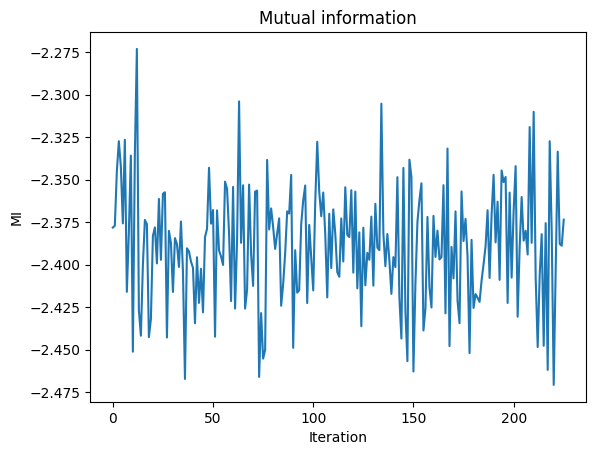

In [71]:
plt.plot(np.arange(0, len(mis)), np.array(mis))
plt.title("Mutual information")
plt.xlabel("Iteration")
plt.ylabel("MI")

In [ ]:
i = 0
di = dis[i]

plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.scatter(di[:, 0], di[:, 1])
plt.title("$d$ at iteration %d" % (i + 1))

Text(0.5, 1.0, 'Points move per iteration (blue is start, orange is end)')

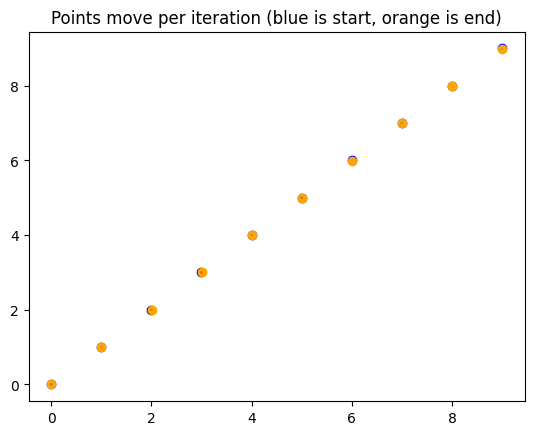

In [72]:
dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.5)
plt.title("Points move per iteration (blue is start, orange is end)")